In [ ]:
!pip uninstall -y oao24
!pip install git+https://github.com/ArcetriAdaptiveOptics/OAO24.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from oao24.package_data import InfraredExampleData, VisibleExampleData
from oao24 import image_processing

In [ ]:
background_image = InfraredExampleData.get_camera_dark_data()
cl_raw_image_cube = InfraredExampleData.get_close_loop_data_cube()
    
ao_image = image_processing.make_master_image(cl_raw_image_cube, background_image)

## Science camera constants


In [9]:
RAD2ARCSEC=180/np.pi*3600
pupil_diameter = 1.52 
wavelength = 1.65e-6 # 1310e-9
# Plate scale is typically saved in the FITS image header
# or it can be calibrated using 2 sources of known distance
# Here we use the Papyrus nominal optical design values
# F/# = 23
# The DL PSF size in m on the focal is F/H * wavelength
cred3_pixel_in_meter = 15e-6
f_number =  23
telescope_focal_length = f_number * pupil_diameter
# so the size of the pixel in arcsec is 
pixel_scale_in_arcsec =cred3_pixel_in_meter / telescope_focal_length * RAD2ARCSEC 

# the DL size (=lambda/D) in units of arcsec or pixels are therefore
dl_size_in_arcsec = wavelength / pupil_diameter * RAD2ARCSEC 
dl_size_in_pixels = dl_size_in_arcsec / pixel_scale_in_arcsec

print("C-Red3 pixel scale: %g arcsec/pixel" % pixel_scale_in_arcsec)
print("DL PSF size: %g arcsec" % dl_size_in_arcsec)
print("DL PSF size: %g pixels" % dl_size_in_pixels)


# We work on a roi of the science image with the star image centered in the field
star_roi = ao_image[240:296, 335:391]
star_roi_cut_index = (29, slice(15, 45))

C-Red3 pixel scale: 0.0885003 arcsec/pixel
DL PSF size: 0.223906 arcsec
DL PSF size: 2.53 pixels


We start simple with a Gaussian fit
Note that the actual PSF is quite similar to a Airy function, as the AO correction is high
Check PSF fitting residual (PSF-GaussianFit)
 

In [10]:
  
amp = star_roi.max()
x0 = np.where(star_roi == star_roi.max())[1][0]
y0 = np.where(star_roi == star_roi.max())[0][0]
sigma_x = 3.6/(2*np.sqrt(2*np.log(2)))
sigma_y = sigma_x

model_gauss = models.Gaussian2D(amp, x0, y0, sigma_x, sigma_y)

fitter = fitting.LevMarLSQFitter()

roi_shape = star_roi.shape
y, x = np.mgrid[:roi_shape[0], :roi_shape[1]]

best_fit_gauss = fitter(model_gauss, x, y, z = star_roi)
psf_residual_gauss= best_fit_gauss(x,y)-star_roi

In [11]:
def display_psf_fit(star_roi, best_fit, psf_residual, star_roi_cut_index, label_fit):
    plt.figure()
    plt.imshow(star_roi)
    plt.colorbar()
    plt.title('PSF')

    plt.figure()
    plt.imshow(psf_residual)
    plt.colorbar()
    plt.title('PSF fitting residual (PSF-%s) std %g' % (label_fit, psf_residual.std())) 

    plt.figure()
    plt.plot(best_fit(x,y)[star_roi_cut_index], label=label_fit)
    plt.plot(star_roi[star_roi_cut_index], label='PSF')
    plt.plot(psf_residual[star_roi_cut_index], label='PSF fitting residual')
    plt.legend()

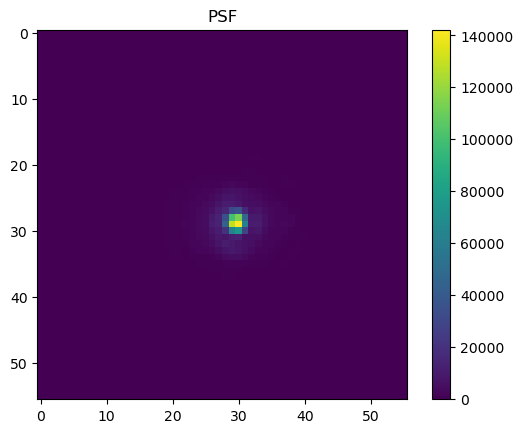

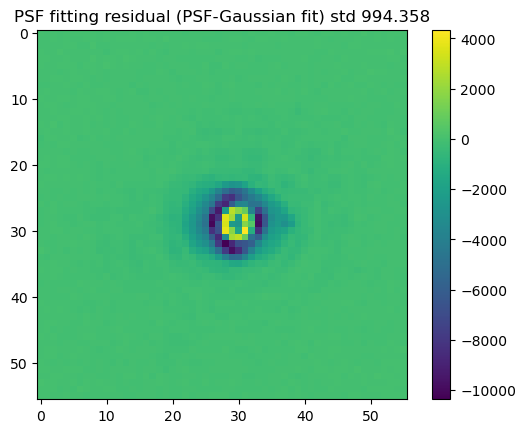

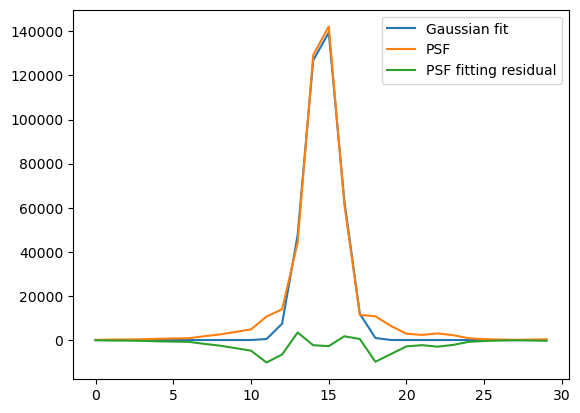

In [12]:
display_psf_fit(star_roi, best_fit_gauss, psf_residual_gauss, star_roi_cut_index, 'Gaussian fit')

Repeat with a Moffat2D model
It is capable of better fitting the PSF wing
Moffat is typically used to fit Seeing limited PSF 

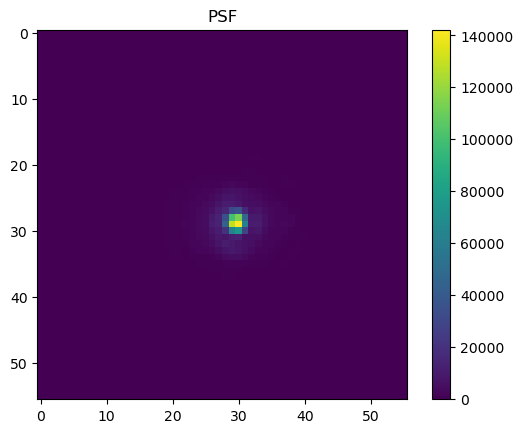

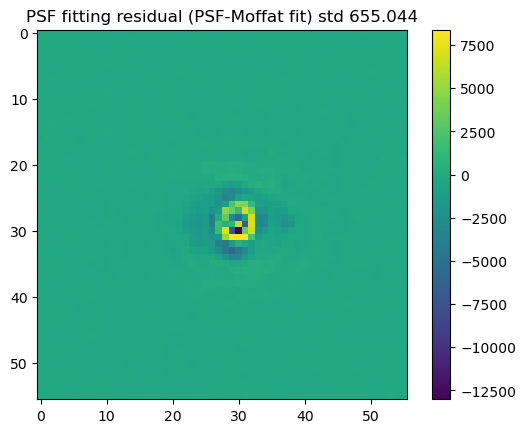

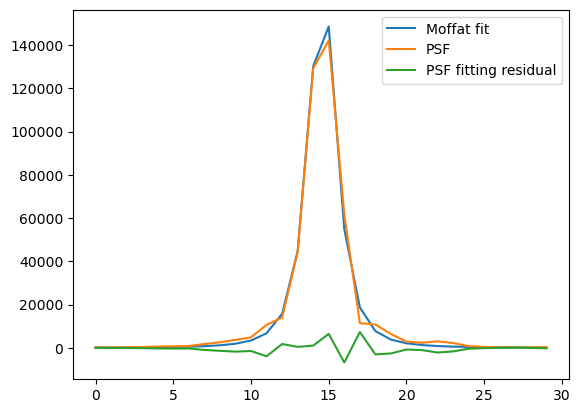

In [13]:
model_moffat = models.Moffat2D(amp, x0, y0, 3.6)
best_fit_moffat = fitter(model_moffat, x, y, z = star_roi)
psf_residual_moffat= best_fit_moffat(x,y)-star_roi

display_psf_fit(star_roi, best_fit_moffat, psf_residual_moffat, star_roi_cut_index, 'Moffat fit')

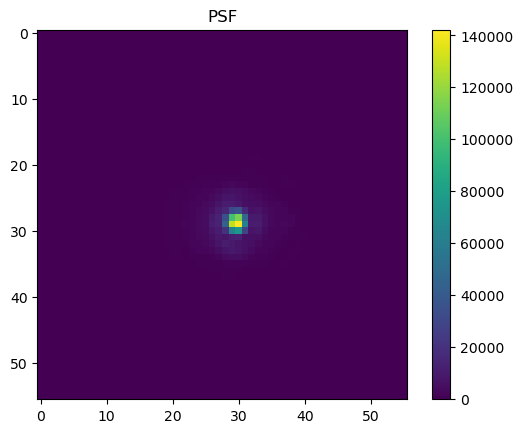

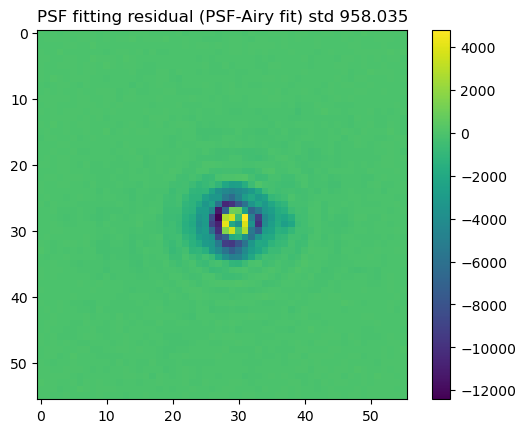

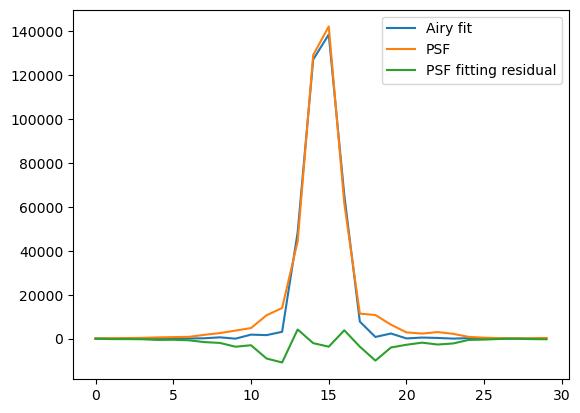

In [14]:
# best_fit_airy = # Create here your best Airy fit
# psf_residual_airy= best_fit_airy(x,y)-star_roi    
# display_psf_fit(star_roi, best_fit_airy, psf_residual_airy, star_roi_cut_index, 'Airy fit')

Compare Gaussian and Moffat

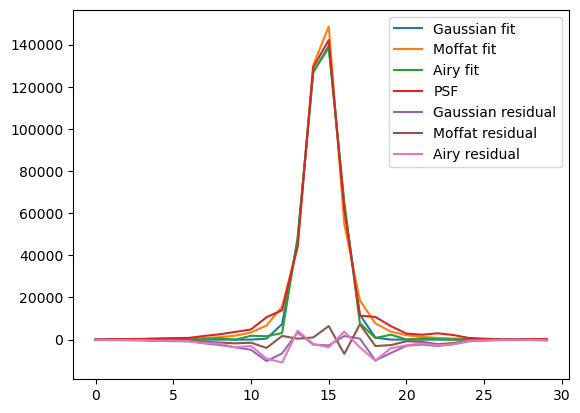

In [23]:
plt.figure()
plt.plot(best_fit_gauss(x,y)[star_roi_cut_index], label='Gaussian fit')
plt.plot(best_fit_moffat(x,y)[star_roi_cut_index], label='Moffat fit')
plt.plot(star_roi[star_roi_cut_index], label='PSF')
plt.plot(psf_residual_gauss[star_roi_cut_index], label='Gaussian residual')
plt.plot(psf_residual_moffat[star_roi_cut_index], label='Moffat residual')
plt.legend()

In [16]:
###
# convert sigma to FWHM!
# average major and minor axis of the Gaussian
# convert from px to arcsec using the plate scale (given or calibrated)
#
# Advanced: PSF ellipticity can tell you something about anisoplanatism, residual astigmatism, wind direction, ...
###

fwhm_gaussian_fit_px = np.mean(best_fit_gauss.parameters[3:5]*(2*np.sqrt(2*np.log(2))))
fwhm_gaussian_fit_arcsec = fwhm_gaussian_fit_px * pixel_scale_in_arcsec
print('FWHM from Gaussian fit %g arcsec' % (fwhm_gaussian_fit_arcsec))

###
# compute FWHM for the Moffat
# convert from px to arcsec using the plate scale (given or calibrated)
###

fwhm_moffat_fit_px  = best_fit_moffat.parameters[3] * 2
fwhm_moffat_fit_arcsec = fwhm_moffat_fit_px * pixel_scale_in_arcsec
print('FWHM from Moffat fit %g arcsec' % fwhm_moffat_fit_arcsec)
print('DL FWHM %g arcsec' % dl_size_in_arcsec) 


FWHM from Gaussian fit 0.22248 arcsec
FWHM from Moffat fit 0.237697 arcsec
DL FWHM 0.223906 arcsec


## Questions
1. Repeat the fit with Airy model `astropy.modeling.functional_models.AiryDisk2D`
1. Advanced: can you improve the fit using a better T152 pupil model? 
1. Repeat the same analysis for the Visible image (Hint: use `VisibleExampleData.get_close_loop_data_cube()`, update wavelengths & co for the ORCA camera: 6.5um/px, 800nm TBC)
1. Estimate the FWHM of the seeing limited image  (NB: the open loop examples images in IR and VIS are not good enough)
